A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

 

Business Goal 

 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [740]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette("deep")

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

In [741]:
houses = pd.read_csv("data/train.csv")

In [742]:
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##### EDA

In [743]:
nulls  = ((houses.isna().sum() / houses.shape[0]) * 100).sort_values(ascending=False)

In [744]:
nulls[nulls > 0]

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

Lot of columns have significant null values. Lets clean the data by removing those columns

In [745]:
houses = houses.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu'], axis=1)

In [746]:
houses = houses.drop(['Id'], axis=1)

In [747]:
houses.nunique().sort_values(ascending=True)

Street             2
Utilities          2
CentralAir         2
HalfBath           3
BsmtHalfBath       3
                ... 
TotalBsmtSF      721
1stFlrSF         753
BsmtUnfSF        780
GrLivArea        861
LotArea         1073
Length: 74, dtype: int64

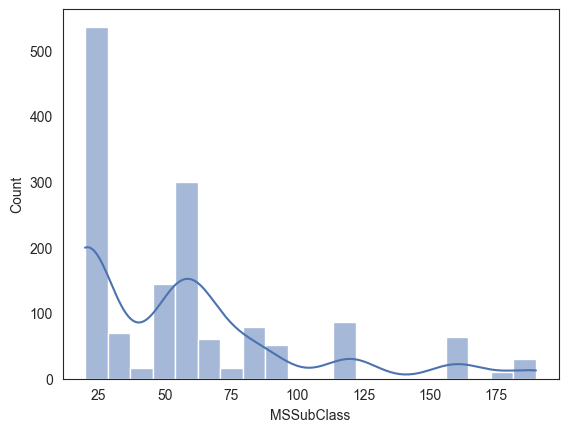

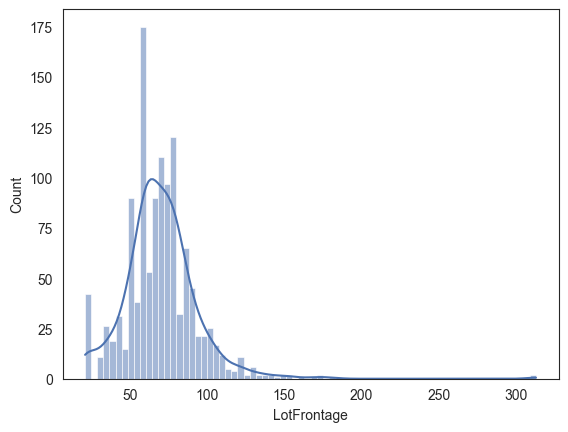

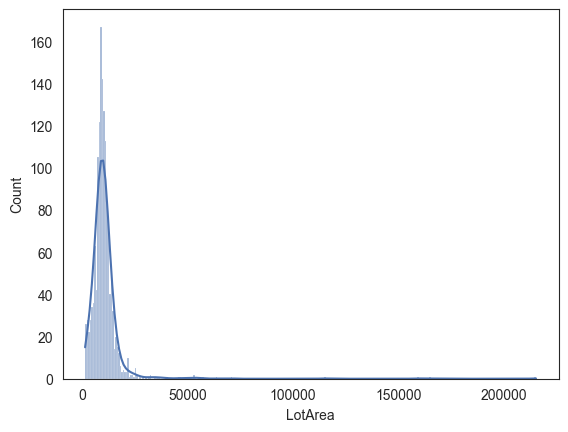

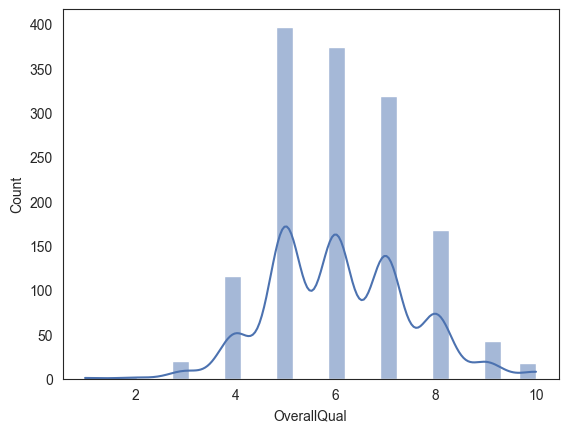

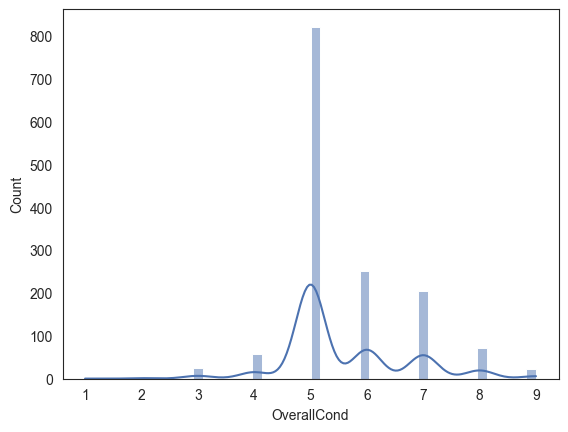

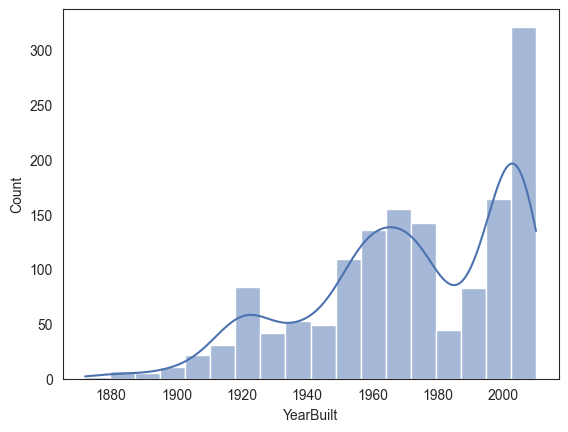

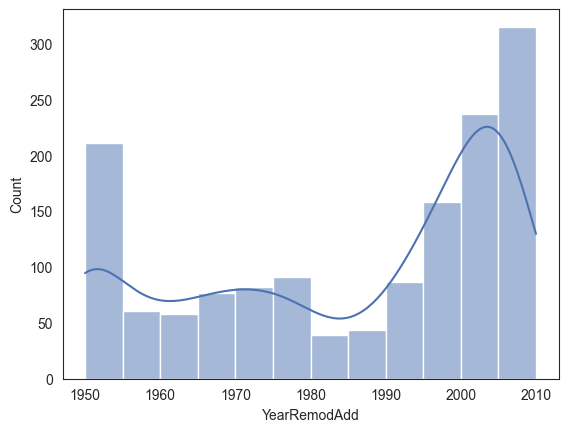

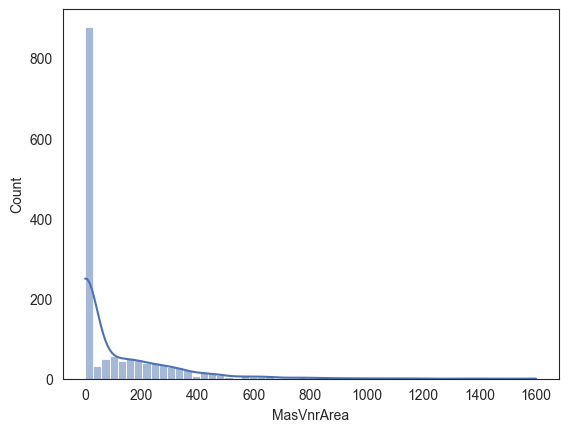

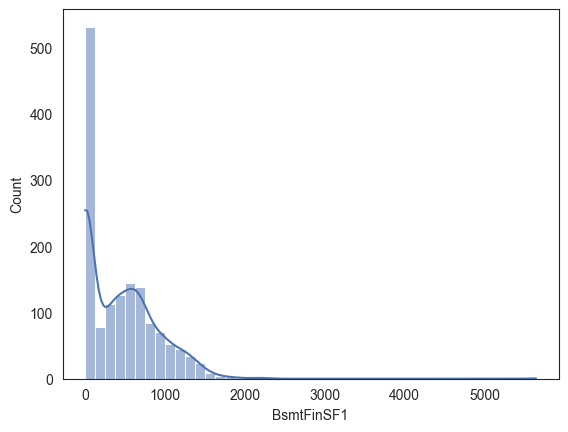

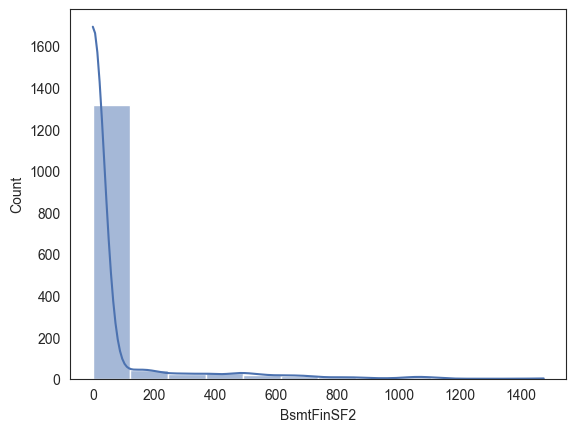

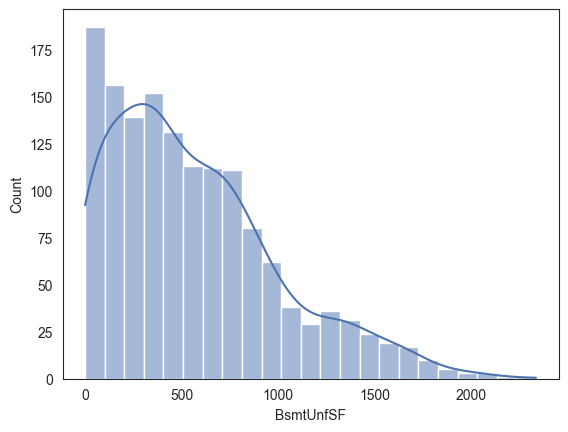

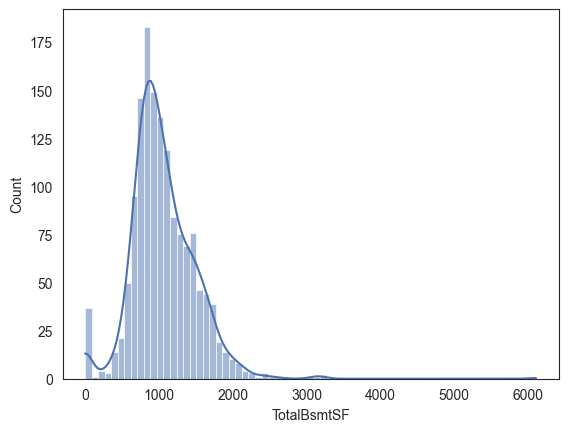

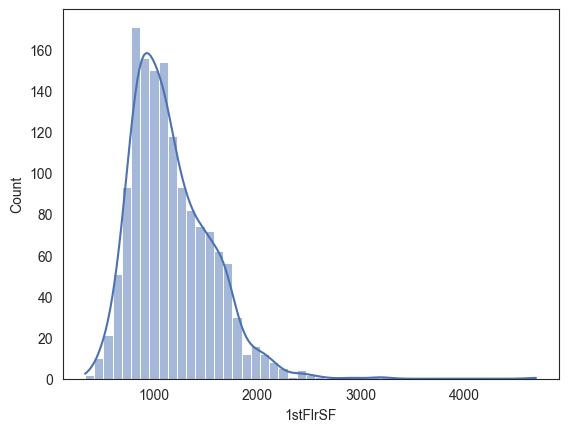

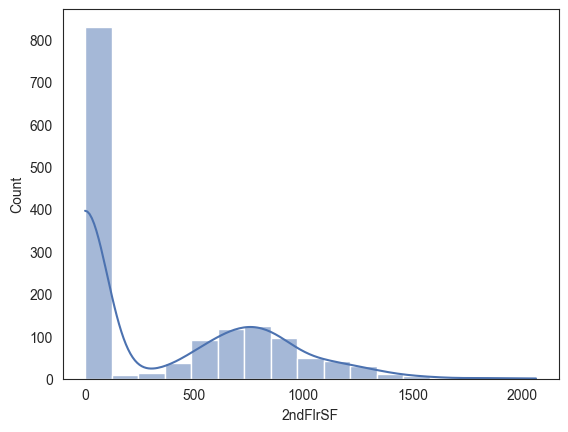

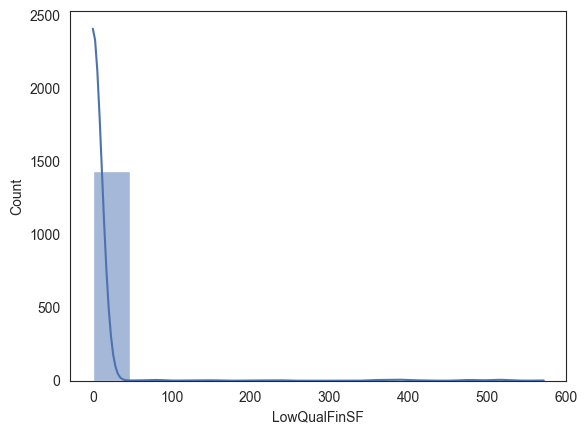

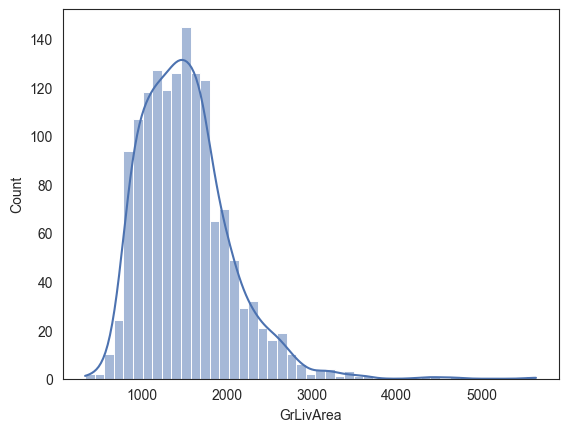

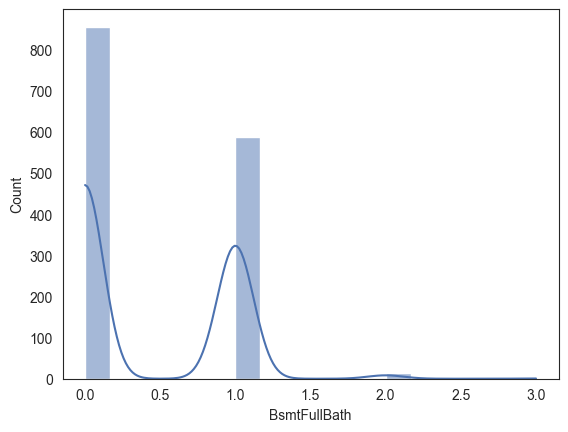

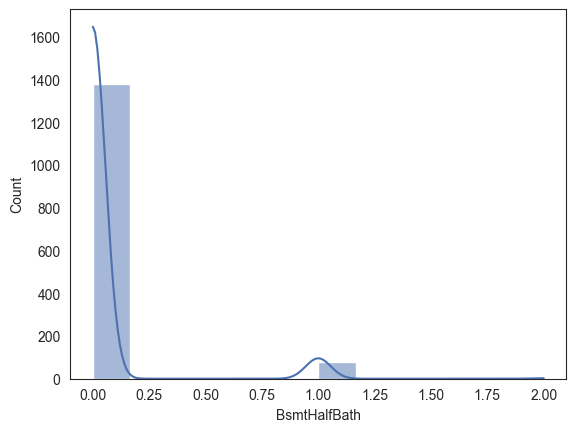

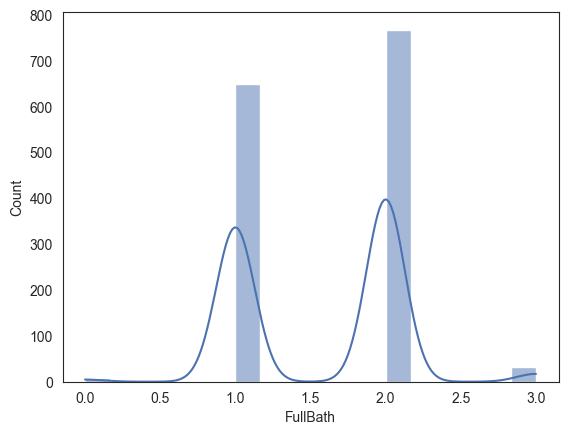

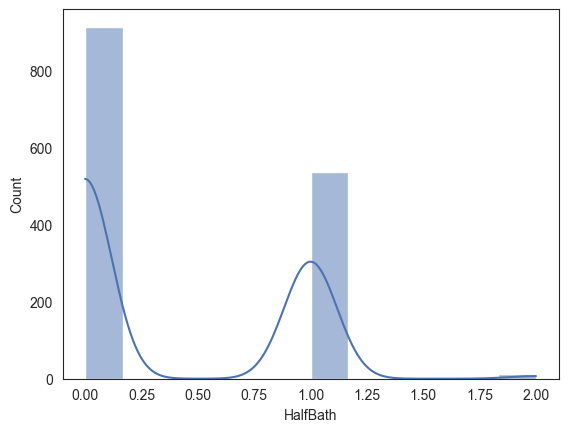

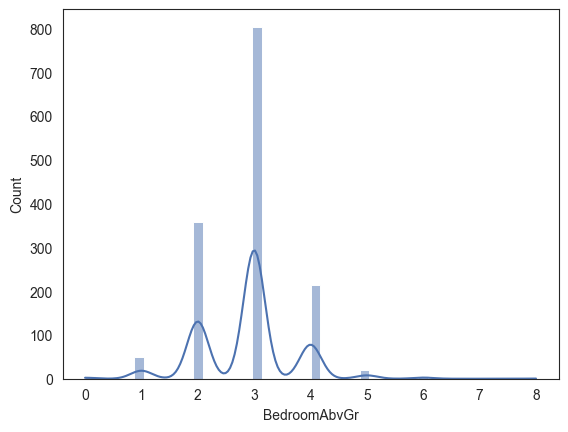

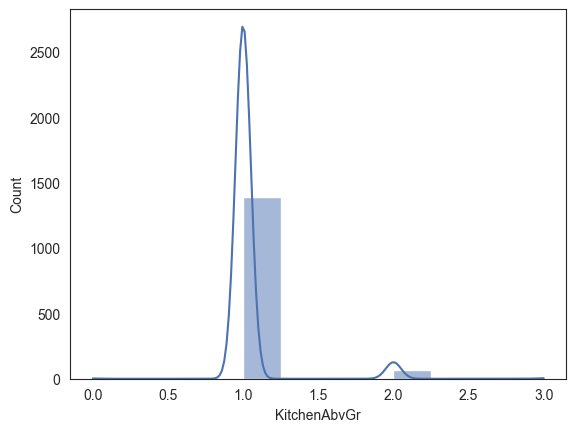

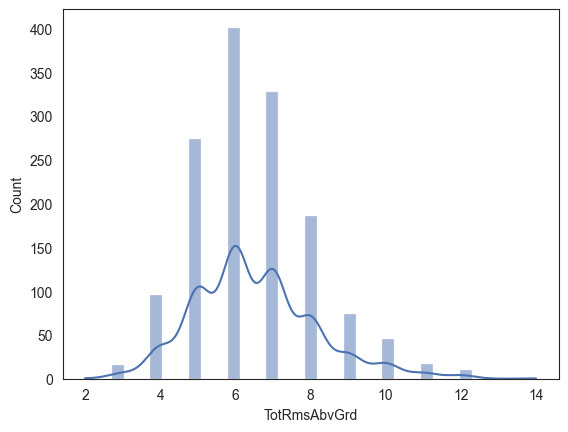

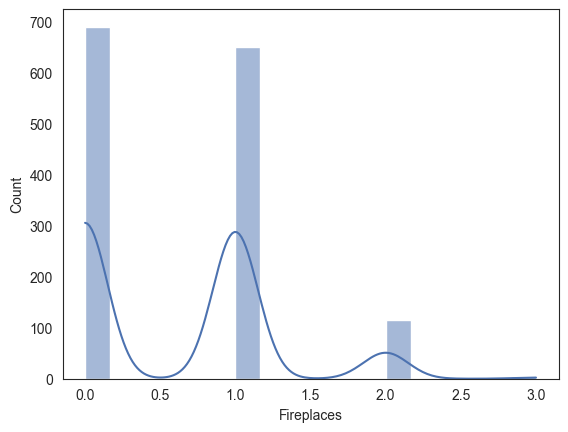

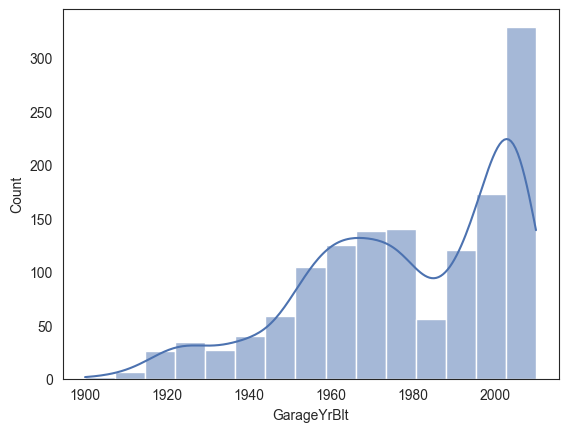

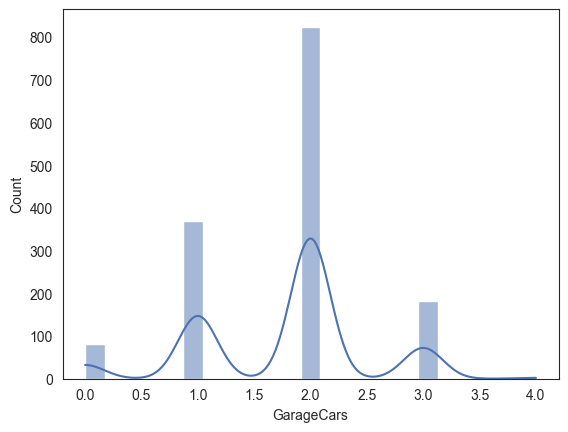

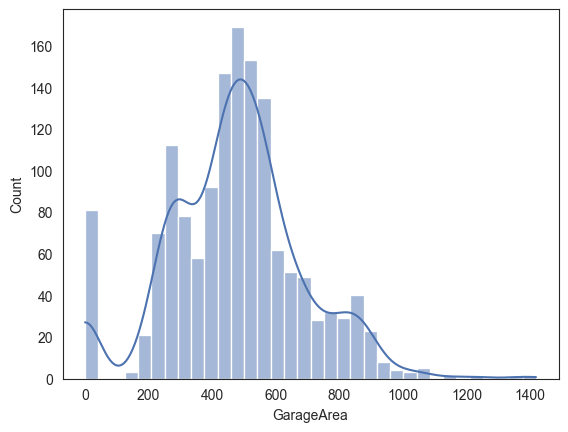

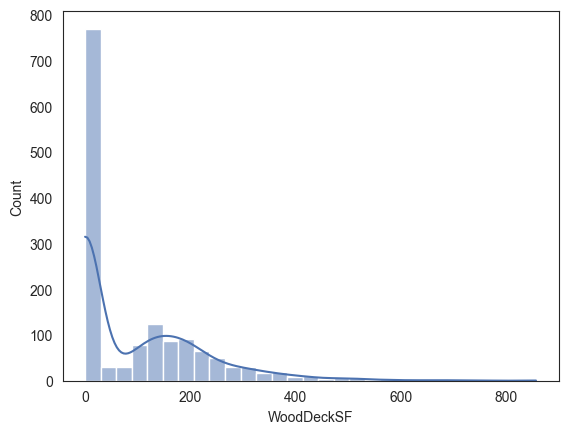

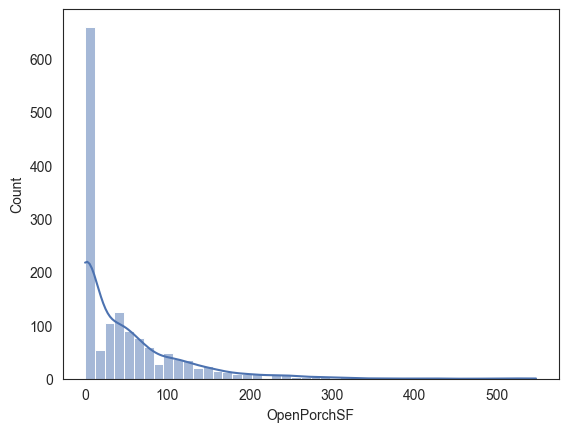

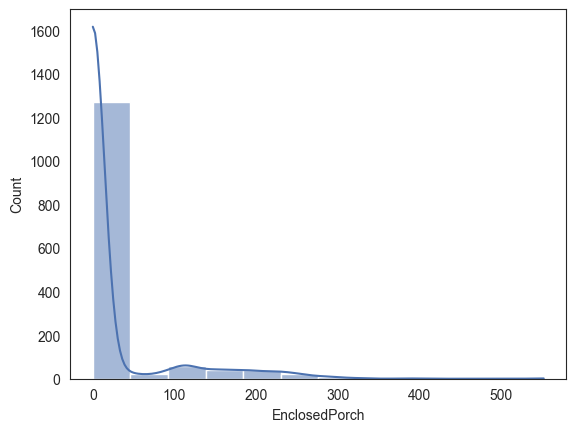

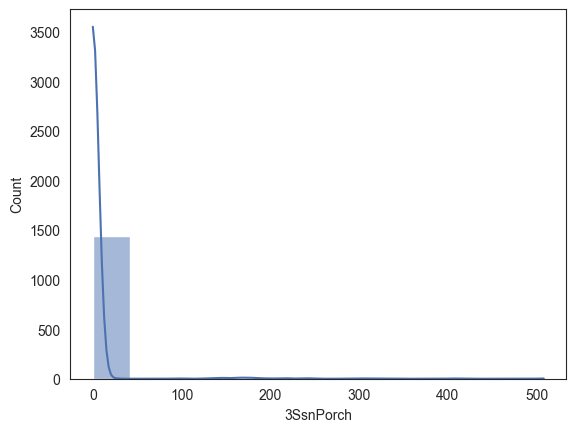

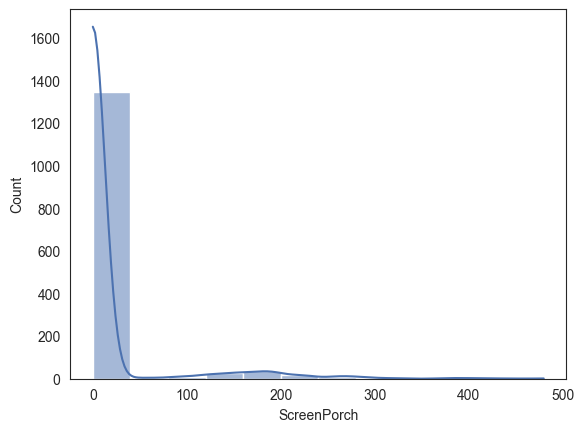

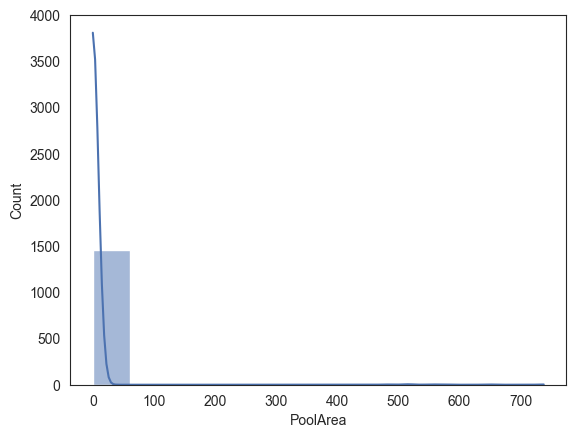

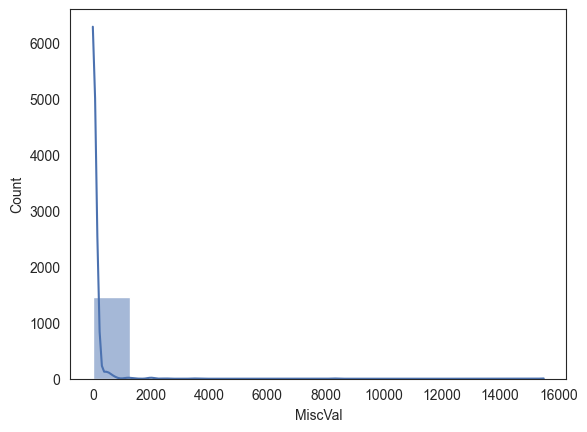

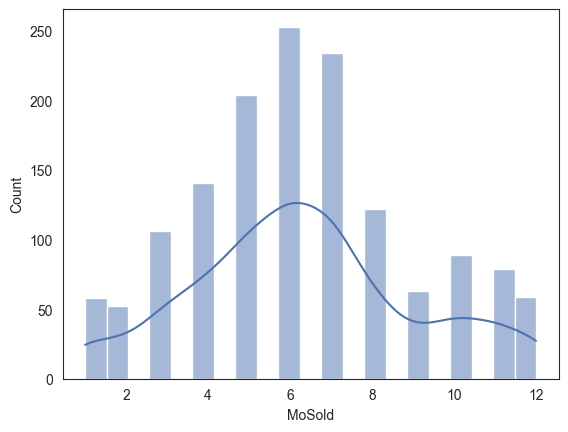

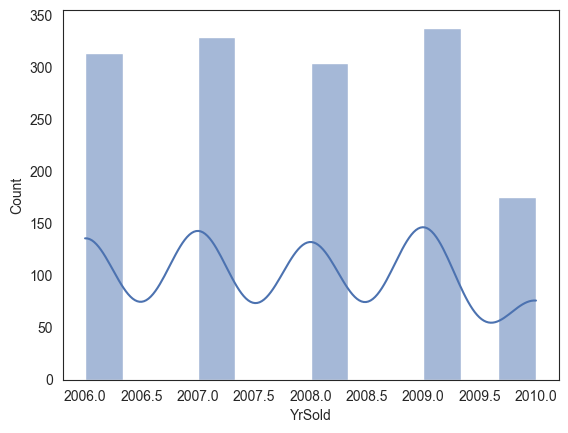

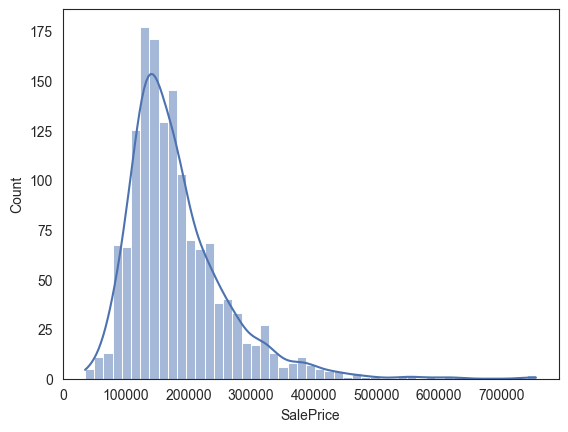

In [748]:
numerical_features=[feature for feature in houses.columns if houses[feature].dtypes!='object']
for feature in numerical_features:
        sns.histplot(data=houses, x=feature, kde=True)
        plt.show()

By observation, almost all values for following features belong to the same bucket of histogram
- LowQualFinSF
- PoolArea
- MiscVal
- 3SsnPorch

Since there is no significant variation, we can safely assume they cannot contribute to a linear relationship to our target variable SalePrice

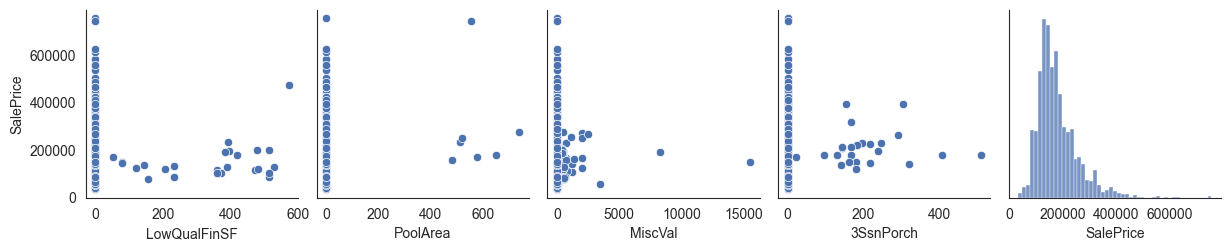

In [749]:
sns.pairplot(data=houses[['LowQualFinSF', 'PoolArea', 'MiscVal', '3SsnPorch', 'SalePrice']], y_vars="SalePrice")
plt.show()

In [750]:
houses = houses.drop(['LowQualFinSF', 'PoolArea', 'MiscVal', '3SsnPorch'], axis=1)

In [751]:
houses.isnull().sum()[houses.isnull().sum()>0]

LotFrontage     259
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

Lets fill missing values

In [752]:
houses['LotFrontage'] = houses['LotFrontage'].fillna(houses['LotFrontage'].median())
houses['MasVnrArea'] = houses['MasVnrArea'].fillna(houses['MasVnrArea'].median())


In [753]:
# NA means no basement
houses['BsmtQual'] = houses['BsmtQual'].fillna('NA')
houses['BsmtCond'] = houses['BsmtCond'].fillna('NA')
houses[houses['BsmtQual'] == 'NA'] = houses[houses['BsmtQual'] == 'NA'].fillna('NA')
houses[houses['BsmtQual'] != 'NA'] = houses[houses['BsmtQual'] != 'NA'].fillna('None')
houses['BsmtFinType1'] = houses['BsmtFinType1'].fillna('NA')
houses['BsmtFinType2'] = houses['BsmtFinType2'].fillna('NA')

# since only one value is missing, use mode
houses['Electrical'] = houses['Electrical'].fillna(houses['Electrical'].mode()[0])

houses['GarageType'] = houses['GarageType'].fillna('NA')
houses['GarageYrBlt'] = houses['GarageYrBlt'].fillna(-1)
houses['GarageFinish'] = houses['GarageFinish'].fillna('NA')
houses['GarageQual'] = houses['GarageQual'].fillna('NA')
houses['GarageCond'] = houses['GarageCond'].fillna('NA')


In [754]:
houses.isna().sum().sum()

0

In [755]:
houses.shape
# Since amount of data is low we can live with some outliers

(1460, 70)

In [756]:
houses['Age'] = houses['YrSold'] -  houses['YearBuilt']
houses = houses.drop(['YrSold', 'YearBuilt'], axis=1)

In [757]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

In [758]:
houses['MSSubClass'] = houses['MSSubClass'].astype(object)

In [759]:
cat_columns = []
for column in houses.columns:
    if houses[column].dtype == object:
        cat_columns.append(column)

In [760]:
# Create dummy variables to explode cat values
for cat in cat_columns:
    cat_df = pd.get_dummies(houses[cat],drop_first=True, prefix=cat)
    houses = pd.concat([houses,cat_df],axis=1)
    houses = houses.drop([cat], axis=1)

In [761]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 351 entries, LotFrontage to SaleCondition_Partial
dtypes: bool(321), float64(2), int64(28)
memory usage: 800.0 KB


In [762]:
houses.shape

(1460, 351)

In [763]:
def remove_correlated_features(x, threshold=0.8, blacklist=[]):
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            if val >= threshold:
                drop_cols.append(col.values[0])
    drops = set(drop_cols)
    for b in blacklist:
        if b in drops:
            drops.remove(b)
    x = x.drop(columns=drops)
    return x

In [764]:
houses = remove_correlated_features(houses, blacklist=['SalePrice'])

In [765]:
houses.shape

(1460, 317)

#### Model Training

##### 1. Linear Regression (W/O Regularization;)

In [766]:
train_houses,test_houses = train_test_split(houses,train_size=0.70,random_state=123)
print(train_houses.shape)
print(test_houses.shape)


(1021, 317)
(439, 317)


In [767]:
scaler = MinMaxScaler()
train_houses[train_houses.columns] = scaler.fit_transform(train_houses[train_houses.columns])

In [768]:
train_houses.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal
250,0.116438,0.018930,0.222222,0.125,0.266667,0.000000,0.000000,0.0,0.311644,0.119149,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
228,0.167808,0.033752,0.444444,0.500,0.283333,0.000000,0.149185,0.0,0.029966,0.149264,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
40,0.215753,0.034392,0.555556,0.500,0.250000,0.086325,0.113926,0.0,0.190497,0.178069,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
428,0.147260,0.025530,0.666667,0.500,0.950000,0.092308,0.117647,0.0,0.232877,0.197709,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
278,0.294521,0.061464,0.888889,0.500,0.950000,0.269231,0.000000,0.0,0.907962,0.347136,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [769]:
y_train = train_houses.pop('SalePrice')
X_train = train_houses

In [770]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

##### Residual Analysis

In [771]:
y_train_pred = lm.predict(X_train)
error_terms = y_train - y_train_pred

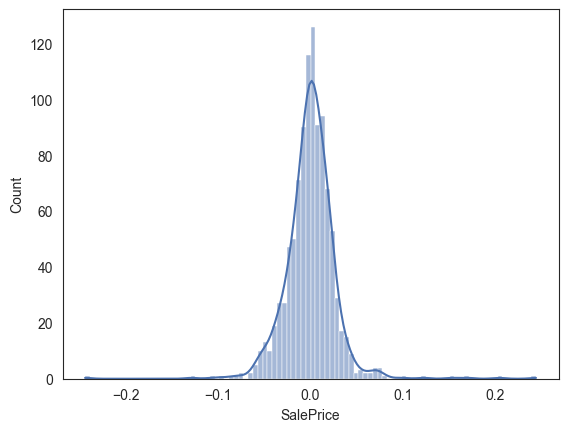

In [772]:
sns.histplot(error_terms, kde=True)
plt.show()

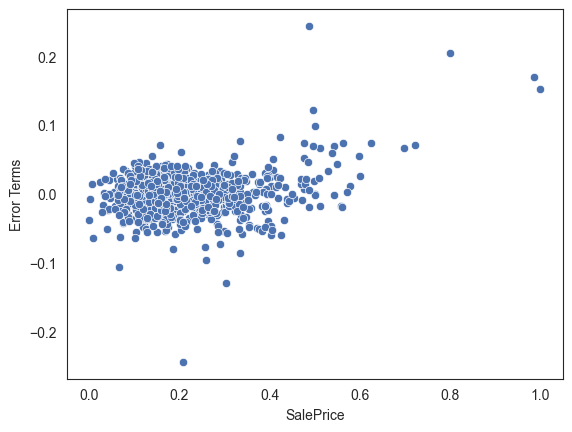

In [773]:
sns.scatterplot(x=y_train,y=error_terms)
plt.ylabel('Error Terms')
plt.show()

In [774]:
test_houses[test_houses.columns] = scaler.transform(test_houses[test_houses.columns])

In [775]:
y_test = test_houses.pop("SalePrice")
X_test = test_houses[X_train.columns]

In [776]:
y_test_pred = lm.predict(X_test)

In [777]:
# Find R^2 score
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"LR R^2 train: {r2_train}")
print(f"LR R^2 test: {r2}")

LR R^2 train: 0.939086838737123
LR R^2 test: -2.4616784772896456e+18


Clearly we can see the model has overfitted on the training data as R^2 for test is very low. We will rectify this problem by using regularization 

In [778]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV

##### Model Training (W Ridge)

In [779]:
param_tuning = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 25, 50, 100, 250, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
cv = GridSearchCV(estimator = ridge, 
                        param_grid = param_tuning, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
cv.fit(X_train, y_train) 

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 25, 50,
                                   100, 250, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [780]:
print(cv.best_params_)

{'alpha': 9.0}


In [781]:
ridge = Ridge(**cv.best_params_)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 5.16682677e-03  1.83256534e-02  8.50902136e-02  2.88944423e-02
  2.04199724e-02  2.30462905e-02  2.57355580e-02  1.39313959e-02
  2.65702708e-02  3.72920654e-02  5.84137888e-02  7.42377639e-02
  2.40424971e-02  2.26027134e-03  5.26202813e-02  1.65954284e-02
  1.17002740e-02 -8.63127231e-03  3.87550437e-02  6.13491179e-02
  2.50893366e-02  1.36497989e-02 -2.41298166e-03  1.21064007e-02
 -2.10741357e-03 -9.57030550e-03 -5.65944274e-03 -5.60475851e-05
  7.88890587e-03  7.33259235e-03 -7.96924826e-04  9.45099349e-03
  4.19880216e-03 -3.36112623e-03 -5.75241520e-03 -1.13818634e-02
 -1.88166934e-02 -1.74820898e-02 -5.51941608e-03 -7.74794933e-03
  9.96789021e-03  8.58955298e-03  1.25488008e-02  1.48565460e-02
  1.61932474e-02 -1.31640346e-02 -1.72750590e-03  2.13618169e-02
  5.65103521e-03  1.33625620e-02 -2.51287008e-03  1.01074982e-02
 -1.17650971e-02 -5.49140793e-03 -3.66461002e-03  1.71459426e-02
  2.34804722e-04 -1.19392862e-03  1.47472955e-03 -2.88818659e-03
 -1.29253280e-02 -1.28068

In [782]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [783]:
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Ridge R^2 train: {r2_train}")
print(f"Ridge R^2 test: {r2}")

Ridge R^2 train: 0.8807292768359967
Ridge R^2 test: 0.8533718998543577


##### Model Training (W Lasso)

In [784]:
lasso = Lasso()

# cross validation
cv = GridSearchCV(estimator = lasso, 
                        param_grid = param_tuning, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

cv.fit(X_train, y_train) 

Fitting 5 folds for each of 29 candidates, totalling 145 fits


In [ ]:
print(cv.best_params_)

{'alpha': 0.0001}


In [ ]:
lasso = Lasso(**cv.best_params_)
lasso.fit(X_train, y_train)
print(lasso.coef_)

[-0.00000000e+00  3.08666867e-02  1.36617188e-01  5.40244010e-02
  1.07563603e-02  0.00000000e+00  0.00000000e+00  4.46479457e-03
 -0.00000000e+00  0.00000000e+00  3.14006850e-02  3.35073488e-01
  2.16883975e-02  0.00000000e+00  2.69998675e-02  6.81485003e-03
 -6.78496866e-03 -2.02362645e-02  2.52144564e-02  6.96292161e-02
  1.97722657e-02  0.00000000e+00 -0.00000000e+00  1.48493092e-02
 -2.39358021e-03 -2.07477698e-02  0.00000000e+00 -0.00000000e+00
  9.17026787e-03  5.59018863e-03 -3.36182666e-03  0.00000000e+00
 -0.00000000e+00  3.94490209e-04 -0.00000000e+00 -8.90859609e-03
 -2.09426767e-02 -1.59191194e-02 -0.00000000e+00 -3.34005196e-03
  1.95851563e-02  0.00000000e+00  6.70373378e-03  2.48250795e-02
  1.56196504e-02 -2.23301870e-02  2.00752069e-04  2.66898922e-02
  1.08318106e-02  1.93400935e-02 -0.00000000e+00  1.25602372e-02
 -2.95382669e-03 -0.00000000e+00 -0.00000000e+00  1.82054975e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.59864039e-03 -0.00000

In [ ]:
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

In [ ]:
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Lasso R^2 train: {r2_train}")
print(f"Lasso R^2 test: {r2}")

Lasso R^2 train: 0.8970948387511263
Lasso R^2 test: 0.8696459941088142


##### Subjective Questions analysis

In [ ]:
ridge = Ridge(alpha=(9*2))
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Ridge R^2 train: {r2_train}")
print(f"Ridge R^2 test: {r2}")

Ridge R^2 train: 0.8619904902345843
Ridge R^2 test: 0.8421244117578138


In [ ]:
ridge_pd = pd.DataFrame(index=X_train.columns)
ridge_pd.rows = X_train.columns
ridge_pd['coeff'] = ridge.coef_
ridge_pd.sort_values(by=['coeff'], ascending=False).head()


,coeff
OverallQual,0.069220
GrLivArea,0.056240
GarageCars,0.052744
Neighborhood_NoRidge,0.051368
Neighborhood_NridgHt,0.049653


In [ ]:
lasso = Lasso(alpha=(0.0001*2))
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Lasso R^2 train: {r2_train}")
print(f"Lasso R^2 test: {r2}")

Lasso R^2 train: 0.882313827271331
Lasso R^2 test: 0.8671438629280646


In [ ]:
lasso_pd = pd.DataFrame(index=X_train.columns)
lasso_pd.rows = X_train.columns
lasso_pd['coeff'] = lasso.coef_
lasso_pd.sort_values(by=['coeff'], ascending=False).head()


,coeff
GrLivArea,0.304106
OverallQual,0.151445
Neighborhood_NoRidge,0.076612
Neighborhood_NridgHt,0.072056
RoofMatl_WdShngl,0.069637


In [ ]:
lasso = Lasso(alpha=(0.0001))
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
lasso_pd = pd.DataFrame(index=X_train.columns)
lasso_pd.rows = X_train.columns
lasso_pd['coeff'] = lasso.coef_
lasso_pd.sort_values(by=['coeff'], ascending=False).head()

,coeff
GrLivArea,0.335073
OverallQual,0.136617
RoofMatl_WdShngl,0.111923
Neighborhood_NoRidge,0.072496
Neighborhood_NridgHt,0.072127


In [ ]:
X_train_3 = X_train.copy()
X_test_3 = X_test.copy()
X_train_3 = X_train_3.drop(['GrLivArea', 'OverallQual','RoofMatl_WdShngl', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt'], axis=1)
X_test_3 = X_test_3.drop(['GrLivArea', 'OverallQual','RoofMatl_WdShngl', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt'], axis=1)

In [ ]:
lasso = Lasso()

# cross validation
cv = GridSearchCV(estimator = lasso, 
                        param_grid = param_tuning, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

cv.fit(X_train_3, y_train) 

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 25, 50,
                                   100, 250, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [ ]:
lasso = Lasso(**cv.best_params_)
lasso.fit(X_train_3, y_train)
y_train_pred = lasso.predict(X_train_3)
y_test_pred = lasso.predict(X_test_3)
lasso_pd = pd.DataFrame(index=X_train_3.columns)
lasso_pd.rows = X_train_3.columns
lasso_pd['coeff'] = lasso.coef_
lasso_pd.sort_values(by=['coeff'], ascending=False).head()

,coeff
TotalBsmtSF,0.319153
2ndFlrSF,0.166349
GarageCars,0.100258
LotArea,0.088457
Exterior2nd_ImStucc,0.063517
